# Работа с открытыми данными

## на примере общественного транспорта ЗелАО

Данные получены с data.gov.ru, data.mos.ru, содержат информацию об остановках, магазинов и границах АО г.Москвы.

Целью данного исследования является получение навыков работы с открытыми данными. Работа включает в себя их получение через API, изучение структуры и формата, интерактивную визуализацию и первичный анализ.

В работе используются: Python3, pandas, folium

Здесь используются предварительно скачанные наборы данных (работа с API описана у меня в [блоге](https://nikser.ru/izuchaiem-api-portala-otkrytykh-dannykh/))

**Оглавление**
<div id="toc"></div>  

In [1]:
import re
import pandas as pd

import folium
from folium import plugins

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Считываем данные

На мой взгляд формат `json` сочетает в себе удобство человеческого и машинного восприятий. Используем очень простой в применении метод `read_json` модуля Pandas. Попутно взглянем на размерность данных и выведем первые пять объектов.

In [3]:
data = pd.read_json('data/data-20160816T0100.json')
data.shape

(10684, 15)

In [4]:
data.head()

,AdmArea,Direction,District,EntryState,ID,Latitude_WGS84,Longitude_WGS84,Name,OperatingOrgName,Pavilion,RouteNumbers,StationName,Street,global_id,system_object_id
0,Северный административный округ,в центр,район Восточное Дегунино,активна,35,55.891500,37.557284,"«Ин-т Стали», Дубнинская улица (в центр)",ГУП «Мосгортранс»,да,А179; А167; А799; А677,Ин-т Стали,Дубнинская улица,1715969,35
1,Северный административный округ,от центра,Тимирязевский район,активна,86,55.836824,37.575172,"«Метро Петровско-Разумовская», Локомотивный пр...",ГУП «Мосгортранс»,да,А194; А63,Метро Петровско-Разумовская,Локомотивный проезд,1716005,86
2,Северный административный округ,в центр,Дмитровский район,активна,132,55.885313,37.521475,"«Учебный центр», Клязьминская улица (в центр)",ГУП «Мосгортранс»,да,А194; А665; А200; А191,Учебный центр,Клязьминская улица,1716027,132
3,Северный административный округ,от центра,Бескудниковский район,активна,179,55.873614,37.536711,"«Ин-т Микрохирургии глаза», Бескудниковский бу...",ГУП «Мосгортранс»,да,А114; А167; А206; А154,Ин-т Микрохирургии глаза,Бескудниковский бульвар,1716031,179
4,Северный административный округ,от центра,Бескудниковский район,активна,177,55.873823,37.545946,"«Бескудниково», Бескудниковский бульвар (от це...",ГУП «Мосгортранс»,да,А114; А167; А206; А154,Бескудниково,Бескудниковский бульвар,1716041,177


## Количество остановок по административным округам

In [5]:
data.AdmArea.value_counts()

Восточный административный округ           1387
Южный административный округ               1367
Западный административный округ            1184
Юго-Восточный административный округ       1082
Юго-Западный административный округ        1064
Северо-Восточный административный округ    1061
Северный административный округ             997
Центральный административный округ          926
Северо-Западный административный округ      763
Новомосковский административный округ       319
Троицкий административный округ             292
Зеленоградский административный округ       242
Name: AdmArea, dtype: int64

### Остановимся пока на Зеленоградском административном округе

In [6]:
# скопуруем данные в отдельный объект применив метод copy() с параметром deep=True
data_zelao = data.loc[data.AdmArea == 'Зеленоградский административный округ', :].copy(deep=True)

### Чистка данных

In [7]:
# посчитаем количество пропусков по столбцам
containNan = {col: sum(data_zelao[col].isnull()) for col in data_zelao.columns.values}
containNan

{'AdmArea': 0,
 'Direction': 0,
 'District': 0,
 'EntryState': 0,
 'ID': 0,
 'Latitude_WGS84': 0,
 'Longitude_WGS84': 0,
 'Name': 0,
 'OperatingOrgName': 46,
 'Pavilion': 0,
 'RouteNumbers': 0,
 'StationName': 0,
 'Street': 0,
 'global_id': 0,
 'system_object_id': 0}

In [8]:
# заменим пропуски признака 'OperatingOrgName' на произвольное значение. 
data_zelao.loc[data_zelao.OperatingOrgName.isnull(), 'OperatingOrgName'] = 'Неизвестно'

### Добавляем остановки на карту

In [9]:
# Вычислим начальную точку усреднив широту и долготу по всему набору данных
start_point = (data_zelao.Latitude_WGS84.mean(), data_zelao.Longitude_WGS84.mean())
start_point

(55.985421141381245, 37.189799419081368)

In [10]:
map_zel= folium.Map(location=start_point, zoom_start=13)

# добавим границы города
folium.GeoJson(open('data/ao.geojson'),
               name='geojson'
              ).add_to(map_zel)
# добавим остановки
for dataslice in data_zelao.ix[:, ['Latitude_WGS84', 'Longitude_WGS84', 'Name']].values:
    folium.Marker(dataslice[:2], popup=dataslice[-1]).add_to(map_zel)
    
map_zel

Видно, что подавляющее большинство остановок расположено вдоль крупных дорог, внутри микрорайонов автобусы не ходят.

### Длина маршрутов

In [11]:
# преобразуем строку маршрутов в список
def clear_routes(routes):
    return [re.sub(r'з-', '', route.strip().lower()) for route in routes.strip().split(';')]

route_per_stop = data_zelao.RouteNumbers.apply(clear_routes)
stop_per_route = route_per_stop.apply(pd.Series).unstack().dropna().value_counts()

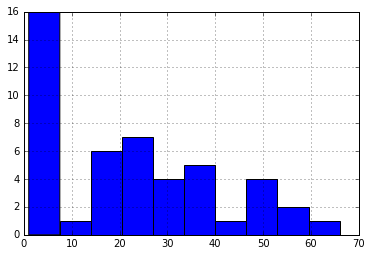

In [12]:
stop_per_route.hist()

pylab.show()

In [13]:
# самые длинные маршруты
stop_per_route.head(5)

а1     66
а11    56
а19    53
а10    50
а2     49
dtype: int64

In [14]:
stop_per_route.describe()

count    47.000000
mean     22.276596
std      17.791916
min       1.000000
25%       5.500000
50%      21.000000
75%      35.500000
max      66.000000
dtype: float64

In [15]:
# выкинем междугородние автобусы
stop_per_route[stop_per_route > 9].describe()

count    31.000000
mean     31.806452
std      14.413927
min      10.000000
25%      21.000000
50%      27.000000
75%      42.500000
max      66.000000
dtype: float64

Здесь посчитано количество остановок в обе стороны маршрута. 

На гистограмме около 16 маршрутов с числом остановок меньше 10, скорее всего это междугородние маршруты, у которых основная часть пути расположена за пределами города.

В пределах города среднее число остановок в обе стороны 32, 25% маршрутов имеют больше 43 остановок в обе стороны.

## Самые загруженные остановки 

In [16]:
data_zelao['RouteCounts'] = route_per_stop.apply(lambda buses: len(buses))

In [17]:
data_zelao.sort_values(by='RouteCounts', ascending=False)[['Name', 'RouteCounts']].head(6)

,Name,RouteCounts
3154,"«Берёзка», проспект Генерала Алексеева (от цен...",19
8833,"«Берёзка», проспект Генерала Алексеева (в центр)",16
1933,"«Автокомбинат», 1-й Западный проезд (в центр)",16
6882,"«Автокомбинат», 1-й Западный проезд (от центра)",15
1960,"«Ст. Крюково (выс.)», Крюковская площадь (в це...",15
4667,"«К/т Электрон», Центральный проспект (от центра)",13


### Уберем визуальный шум

Используем кластеры маркеров, чтобы сгруппировать остановки

In [18]:
stops_map = folium.Map(location=start_point, tiles='Stamen Toner', zoom_start=13)
marker_cluster = folium.MarkerCluster().add_to(stops_map)
for name, row in data_zelao.iterrows():
    folium.Marker([row["Latitude_WGS84"], row["Longitude_WGS84"]], popup="{0}: {1}".format(row["District"], row["Name"])).add_to(marker_cluster)
#stops_map.save('stops.html')
stops_map

### Визуализация плотности расположения остановок

Представим количество остановок более наглядно используя тепловую карту

In [19]:
stops_heatmap = folium.Map(location=start_point, zoom_start=13)

folium.GeoJson(open('data/ao.geojson'), name='geojson').add_to(stops_heatmap)

stops_heatmap.add_children(plugins.HeatMap( \
                        [[row["Latitude_WGS84"], row["Longitude_WGS84"]] for name, row in data_zelao.iterrows()]))

stops_heatmap

Плотнось расположения остановок достигает максимума в районе ж.д. платформы, где большой поток людей с электричек, а также находится мост через ж.д. пути. 

## Расположение алкогольных магазинов

Данный набор был предварительно получен через API и отфильтрован по ЗелАО.

In [20]:
folium.GeoJson(open('data/alcomalls.geojson'), name='geojson').add_to(stops_heatmap)
stops_heatmap

## Заключение

Наборы открытых данных в целом чистые, поддерживают форматы json, geojson. Данные находятся в актуальном состоянии (август 2016г). Для проведения аналитики желательно иметь большую детализированность данных и их количество.